In [1]:
# Importing all the required libraries

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch import optim
from torchvision import transforms
from torch.autograd import Variable

from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
from torch.autograd import Variable

from ipykernel import kernelapp as app
from tqdm.autonotebook import tqdm

from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
cmap = plt.cm.jet
from matplotlib.pyplot import imshow

from datetime import datetime

import time
import cv2
import pandas as pd
import numpy as np
import os
import random
import glob
import pickle
import csv

from sklearn.metrics import accuracy_score

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import backend as tf_keras_backend
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

tf_keras_backend.set_image_data_format('channels_last')
tf_keras_backend.image_data_format()

import warnings
warnings.filterwarnings('ignore')


## Preprocessing Images to same dimensions

In [2]:
def padding(image, old_width, old_height, new_width, new_height):
    h1, h2 = int((new_height - old_height) / 2), int((new_height - old_height) / 2) + old_height
    w1, w2 = int((new_width - old_width) / 2), int((new_width - old_width) / 2) + old_width
    image_pad = np.ones([new_height, new_width, 3]) * 255
    image_pad[h1:h2, w1:w2, :] = image
    return image_pad


def set_size(image, target_w, target_h):
    h, w = image.shape[:2]
    if w < target_w and h < target_h:
        image = padding(image, w, h, target_w, target_h)
    elif w >= target_w and h < target_h:
        new_width = target_w
        new_height = int(h * new_width / w)
        new_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)
        image = padding(new_image, new_width, new_height, target_w, target_h)
    elif w < target_w and h >= target_h:
        new_height = target_h
        new_width = int(w * new_height / h)
        new_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)
        image = padding(new_image, new_width, new_height, target_w, target_h)
    else:
        """w>=target_w and h>=target_h """
        ratio = max(w / target_w, h / target_h)
        new_width = max(min(target_w, int(w / ratio)), 1)
        new_height = max(min(target_h, int(h / ratio)), 1)
        new_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)
        image = padding(new_image, new_width, new_height, target_w, target_h)
    return image


def preprocess_image (path, image_w, image_h):
    """ Pre-processing image for predicting """
    image = cv2.imread(path)
    image = set_size(image, image_w, image_h)

    image = np.clip(image, 0, 255)
    image = np.uint8(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    image = image.astype(np.float32)
    image /= 255
    return image

### Required Paths

In [3]:
# Getting current working directory to get back to this directory easily
cwd=os.getcwd()
images_path='C:\\Users\\jimev\\Desktop\\Project_Data\\Words\\'
labels_path='C:\\Users\\jimev\\Desktop\\Project_Data\\Words\\words.txt'

In [4]:
# Number of classes in the data
classes = '_!"#&\'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz '

In [5]:
len(classes)

80

In [6]:
def getLabelArray(label):
    return list(map(lambda x: classes.index(x), label))

def getActualLabel(labels):
    return ''.join(list(map(lambda x: classes[int(x)], labels)))

In [7]:
def getInfo(filepath):    
    
    fp=open(filepath, 'r')
    data=[]
    #len16=[]
    #len0=[]
    bad_images=[]
    for item in fp:
        if item[0]=='#':
            continue
        #print (item)
        items=item.strip().split(' ')

        #print(items)
        filename=items[0]
        filename=filename.split('-')
        filepath=images_path+filename[0]+'/'+filename[0]+'-'+filename[1]+'/'+ \
            filename[0]+'-'+filename[1]+'-'+filename[2]+'-'+filename[3]+'.png'


        if not os.path.getsize(filepath):
            bad_images.append(filename[0]+'-'+filename[1]+'-'+filename[2]+'-'+filename[3]+'.png')
            continue
        
        label=' '.join(elem for elem in items[8:])
        if len(label)>16:
            #print('Length greater than 16 found')
            #len16.append([filepath, label])
            continue
        #if len(label)<=0 or label==None:
            #print('None Value found')
            #len0.append([filepath, label])
        
        data.append([filepath, label])
    fp.close()
    return data

In [8]:
data=getInfo(labels_path)

## Before Preprocessing

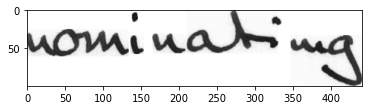

nominating 




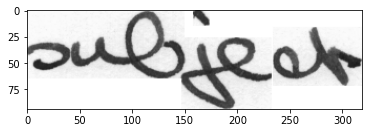

subject 




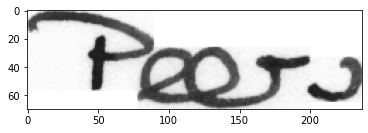

Peers 




In [9]:
random.seed(123)
count=0
while count!=3:
    value=random.randint(1, 100)
    image_info=data[value]
    #print(line)
    path=image_info[0]
    #print(path)
    image = cv2.imread(path)
    imageplot = plt.imshow(image)
    plt.show()
    #print(line)
    label=image_info[1]#getActualText(np.array(line[1]))
    print(label, '\n\n')
    count+=1
        

## After Preprocessing

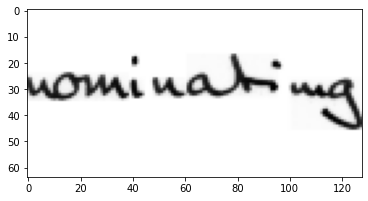

nominating 




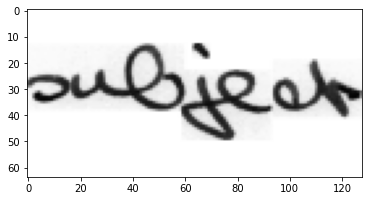

subject 




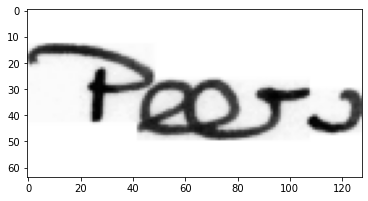

Peers 




In [10]:
random.seed(123)
count=0
while count!=3:
    value=random.randint(1, 100)
    image_info=data[value]
    #print(line)
    path=image_info[0]
    #print(path)
    image=preprocess_image(path, 128, 64)
    
    plt.imsave('temp.png', image, cmap='gray')
    image = cv2.imread(cwd+'\\temp.png')
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #image = image.convert('RGB')
    
    #image = mpimage.imread(path)
    imageplot = plt.imshow(image)
    plt.show()
    #print(line)
    label=image_info[1]#getActualText(np.array(line[1]))
    print(label, '\n\n')
    count+=1
    #os.remove('temp.png')
        

Train, Test, Validation Split

In [11]:
train_paths=data[:int((0.8)*len(data))]
test_paths=data[int((0.8)*len(data)):int((0.90)*len(data))]
val_paths=data[int((0.90)*len(data)):]

In [23]:
class MyDataLoader(Dataset):
    
    def __init__(self, data_file, transform=None):
        
        self.data_file = data_file
        self.transform = transform
        self.imagepaths=[]
        self.labels=[]
        
        for i, (image_path, label) in enumerate(data_file):
            self.imagepaths.append(image_path)
            self.labels.append(label)
    
    def __len__(self):
        return len(self.imagepaths)
    

    def __getitem__(self, idx):
        imagepath=self.imagepaths[idx]
        label=self.labels[idx]
        #label=getLabelArray(label)
        #label=list(label)
        #label=ASCIISentence(label)
        image=preprocess_image(imagepath, 128, 128)
        plt.imsave('temp.png', image, cmap='gray')
        image = Image.open(cwd+'\\temp.png')
        image = image.convert('RGB')
        os.remove('temp.png')
        
        #image = np.swapaxes(image, 2, 0)
        #image = np.expand_dims(image, axis=-1)  # Equivalent to x[:,:,np.newaxis]
        #image=Image.open(imagepath)
        #image=preprocess(cv2.imread(imagepath, cv2.IMREAD_GRAYSCALE), (128,32))
        #image = image.convert('RGB')
        
        if self.transform is not None:
            image=self.transform(image)
        #l=[]
        #label=(getLabelArray(label))
        #l.append(label)
        #print(l)
        #break
        return image, label

In [24]:
# transformations on the data
transformations = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [25]:
train_set=MyDataLoader(train_paths, transform=transformations)
test_set=MyDataLoader(test_paths, transform=transformations)

In [26]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size= 32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size= 32, shuffle=True)

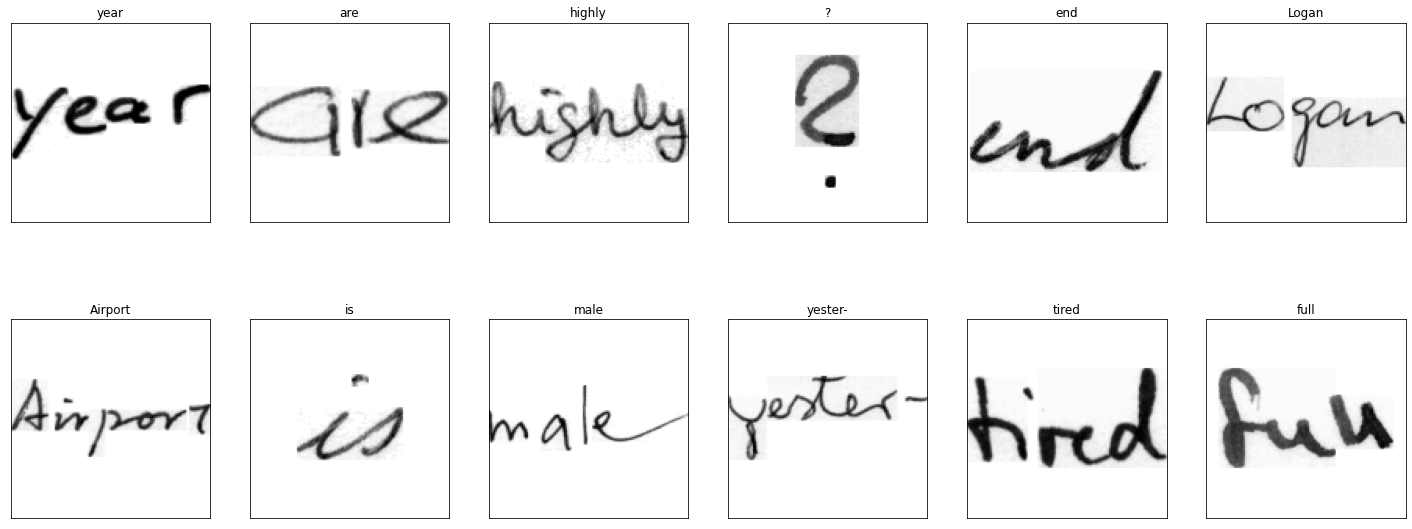

In [28]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
# plot the images in the batch, along with the corresponding labels
### print(dataiter.next())
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 10))
plot_size=12
for idx in np.arange(12):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    #images[idx]=np.swapaxes(images[idx], 2, 0)
    ax.imshow(images[idx][0], cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    #print(labels[idx])
    ax.set_title(labels[idx])
    

In [29]:
def moveTo(obj, device):
    '''
    Function moved the obj to the availble device--> either cpu or cuda
    obj: object
    device: cpu or gpu
    '''
    if isinstance(obj, tuple):
        return tuple([moveTo(x, device) for x in obj])
    elif isinstance(obj, list):
        return [moveTo(x, device) for x in obj]
    elif isinstance(obj, torch.Tensor):
        return obj.to(device)
    else:
        return x

In [30]:
def train_network(model, loss_func, train_loader, val_loader=None, score_funcs=None, 
                         epochs=10, device="cpu", checkpoint_file=None, 
                         lr_schedule=None, optimizer=None, disable_tqdm=False
                        ):
    """Train simple neural networks
    
    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs. 
    val_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute lodation to perform training
    
    """
    if score_funcs == None:
        score_funcs = {}#Empty set 
    
    to_track = ["epoch", "total time", "train loss"]
    if val_loader is not None:
        to_track.append("val loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if val_loader is not None:
            to_track.append("val " + eval_score )
        
    total_train_time = 0 #How long have we spent in the training loop? 
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []

        
    if optimizer == None:
        #The AdamW optimizer is a good default optimizer
        optimizer = torch.optim.AdamW(model.parameters())
        del_opt = True
    else:
        del_opt = False

    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch", disable=disable_tqdm):
    
        model = model.train()#Put our model in training mode
        running_loss = 0.0
        
        y_true = []
        y_pred = []

        start = time.time()
        for inputs, labels in tqdm(train_loader, desc="Train Batch", leave=False, disable=disable_tqdm):
      
            #Move the batch to the device we are using. 
            inputs = moveTo(inputs, device)
            labels = Variable(torch.IntTensor([cdict[c] for c in ''.join(labels)]))
            label_lens = torch.IntTensor([len(t) for t in transcr])
            labels = moveTo(labels, device)
            
            #batch_size = labels.shape[0]
            batch_size=len(label_lens)

            # PyTorch stores gradients in a mutable data structure. So we need to set it to a clean state before we use it. 
            #Otherwise, it will have old information from a previous iteration
            optimizer.zero_grad()

            y_hat = model(inputs) #this just computed f_Θ(x(i))

            # Compute loss.
            loss = loss_func(y_hat, labels)

            loss.backward()# ∇_Θ just got computed by this one call!

            #Now we just need to update all the parameters! 
            optimizer.step()# Θ_{k+1} = Θ_k − η * ∇_Θ ℓ(y_hat, y)

            #Now we are just grabbing some information we would like to have
            running_loss += loss.item() * batch_size
            
            if len(score_funcs) > 0:
                #moving labels & predictions back to CPU for computing / storing predictions
                labels = labels.detach().cpu().numpy()
                y_hat = y_hat.detach().cpu().numpy()
                for i in range(batch_size):
                    y_true.append(labels[i])
                    y_pred.append(y_hat[i,:])
        #end training epoch
        end = time.time()
        total_train_time += (end-start)
        
        results["epoch"].append( epoch )
        results["total time"].append( total_train_time )
        results["train loss"].append( running_loss )
        
        y_pred = np.asarray(y_pred)
        
        if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
            y_pred = np.argmax(y_pred, axis=1)
            
        for name, score_func in score_funcs.items():
            results["train " + name].append( score_func(y_true, y_pred) )
      
        if val_loader is None:
            pass
        else:#Lets find out validation performance as we go!
            model = model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!

            y_true = []
            y_pred = []
            
            val_running_loss = 0.0

            for inputs, labels in val_loader:
        
                #Move the batch to the device we are using. 
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                batch_size = labels.shape[0]
        
                y_hat = model(inputs)
            
                loss = loss_func(y_hat, labels)
                
                #Now we are just grabbing some information we would like to have
                val_running_loss += loss.item() * batch_size

                if len(score_funcs) > 0:
                    #moving labels & predictions back to CPU for computing / storing predictions
                    labels = labels.detach().cpu().numpy()
                    y_hat = y_hat.detach().cpu().numpy()
                    for i in range(batch_size):
                        y_true.append(labels[i])
                        y_pred.append(y_hat[i,:])
                        
            results["val loss"].append( running_loss )

            y_pred = np.asarray(y_pred)

            if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
                y_pred = np.argmax(y_pred, axis=1)

            for name, score_func in score_funcs.items():
                results["val " + name].append( score_func(y_true, y_pred) )
        
        #In PyTorch, the convention is to update the learning rate after every epoch
        if not lr_schedule is None:
            if isinstance(lr_schedule, torch.optim.lr_scheduler.ReduceLROnPlateau):
                lr_schedule.step(val_running_loss)
            else:
                lr_schedule.step()
        
        if checkpoint_file is not None:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'results' : results
                }, checkpoint_file)
    if del_opt:
        del optimizer

    return pd.DataFrame.from_dict(results)

In [31]:
### Flatten class referenced from lectures notes
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [32]:
# Loss Function
loss_func=nn.CrossEntropyLoss()